In [1]:
!pip install records boto3 psycopg2-binary &> /dev/null

In [2]:
import boto3
import records
from matplotlib import style
%matplotlib inline
style.use('ggplot')

In [3]:
db_url = boto3.client('ssm').get_parameter(Name='/bikefinder/dev/db_url', WithDecryption=True)['Parameter']['Value']
db = records.Database(db_url)

In [4]:
# number of bikes in operaton per day per provider
bikes_in_service = db.query(
    """
    ( -- number of unique bike_ids per provider (except ofo)
      select created::date, provider, count(distinct bike_id) num_bikes
      from bike_locations
      where provider<>'ofo'
      group by provider, created::date
    )
    union
    ( -- max number of ofo bikes available through out the day
      with ofo as (select * from bike_locations where provider='ofo'),
        counts_per_batch as (select count(bike_id), bike_id, created::date from ofo
                             group by bike_id, created::date)
      select created, 'ofo' provider, max("count") num_bikes
      from counts_per_batch
      group by created
    )
    order by created, provider;
    """).export('df')
bikes_in_service = bikes_in_service.pivot(index='created', columns='provider', values='num_bikes')

In [5]:
bikes_in_service

provider,JUMP,limebike,mobike,ofo,spin
created,,,,,
2018-02-18,54,370,464,338,163
2018-02-19,57,385,470,337,177
2018-02-20,68,391,463,330,185
2018-02-21,75,422,468,295,187
2018-02-22,190,409,461,350,197
2018-02-23,123,399,453,343,204
2018-02-24,69,398,451,323,189
2018-02-25,72,386,442,312,188
2018-02-26,84,402,439,337,186


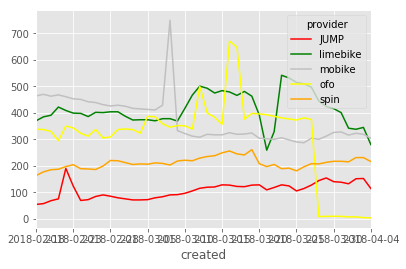

In [28]:
plt = bikes_in_service.plot()
plt.get_lines()[0].set_color('red')
plt.get_legend().get_lines()[0].set_color('red')
plt.get_lines()[1].set_color('green')
plt.get_legend().get_lines()[1].set_color('green')
plt.get_lines()[2].set_color('silver')
plt.get_legend().get_lines()[2].set_color('silver')
plt.get_lines()[3].set_color('yellow')
plt.get_legend().get_lines()[3].set_color('yellow')
plt.get_lines()[4].set_color('orange')
plt.get_legend().get_lines()[4].set_color('orange')

In [7]:
# min,avg,max lifetime of bikes per provider (except ofo, of course)
db.query(
    """
    with bike_lifetimes as (
        select bike_id, provider, max(created) - min(created) age
        from bike_locations
        where provider<>'ofo'
        group by bike_id, provider
    )
    select provider, min(age), avg(age), max(age)
    from bike_lifetimes
    group by provider;
    """).export('df')

,provider,min,avg,max
0,JUMP,0 days,35 days 18:08:52.743469,44 days 04:29:58.606967
1,mobike,0 days,17 days 06:06:07.141599,26 days 06:10:06.054422
2,spin,0 days,27 days 17:40:12.133899,44 days 04:30:11.687546
3,limebike,0 days,17 days 07:40:16.908145,44 days 04:29:57.606723


In [8]:
db.close()
db._engine.dispose()